## Вопрос по выбору (термодинамика, 4 семестр)

# Определение поверхностного натяжения коллоидных частиц $SrSO_4$ с помощью спектрофотометра 

**Цель работы:** изучение процесса гомогенного образования зародышей новой фазы при кристаллизации $SrSO_4$ из раствора, определение коэффициента поверхностного натяжения на границе раствор-частица $SrSO_4$

**В работе использовались:** 
- двухлучевые спектрофотометры [Shimadzu UV-1800](https://www.shimadzu.ru/sites/shimadzu.seg/files/uv-1800-flyer-01.18.pdf)
- кондуктометр [Эксперт-002](https://www.ktopoverit.ru/prof/opisanie/23460-07.pdf) с наливной открытой ячейкой УЭП-Н-С (на 22 мл)
- дозаторы и наконечники для дозатора Ленпипет 
- мерные колбы 50 мл, химические стаканы 100 мл
- прокаленный $Na_2SO_4$, 6-водный $SrCL_2$, дистилированная вода

## Теоретическое введение

- устройство двухлучевого
- теория зельдовича
- поверностное натяжение
- фазовый переход первого рода

## Ход работы

1. Приготовление стоковых растворов $Na_2SO_4$ и $SrCl_2$ по 50 мл, соответствующих максимальному планируемому пересыщению $S = 5$
2. Проверка на кондуктометре концентраций полученных стоковых растворов (1 мл стока, 21 мл дистиллята для кондуктометрической ячейки обьемом 22 мл)
3. Получение гидрозоля $SrSO_4$ суммарным объемом 4000 мкл с пересыщением в диапазоне $2.75 \div 5$, согласно Табл. 1 (см. Приложение)
4. Измерение на спектрофотометре зависимости оптической плотности приготовленного раствора $SrSO_4$ от времени $D(t)$ на длине волны 400 нм в режиме TimeScan
5. Повторение пунктов 2,3 для остальных пересыщений из Табл. 1

## Подготовка к анализу

In [149]:
import pandas as pd
import pandas.io.formats.style as pds

import numpy as np
import scipy.stats as sci
import scipy.optimize as opt

import matplotlib.pyplot as plt
import matplotlib as mpl

Водности веществ (с банок) - 0 для сульфата, 6 для хлорида

In [150]:
# Табличные величины
mol_mass_srcl2, mol_mass_na2so4, mol_mass_srso4 = 1e-3 * (183.68 + 6 * 18), 1e-3 * 142.04, 1e-3 * 183.86 # [г/моль], молярные массы компонентов
C0_srso4 = 3.44 * 1e-7 # ПР в водном растворе при T = 298 K по Никольскому
R = 8.314 # [Дж/мольК]
N_A = 6.02 * 1e23 # [шт/моль]
T = 293 # [К]

Кюветы на 4 мл, пластиковые

In [151]:
# Предварительные расчеты (до проверки концентрации)
# Плановые пересыщения (20 точек в диапазоне от 2.75 до 5)
S_min, S_max = 2.75, 5
S, C = [], []
for _ in range(20):
    s = np.exp((1 / (1 / (np.log(S_max))**2 + (_ / (20 - 1)) * (1 / (np.log(S_min))**2 - 1 / (np.log(S_max))**2)))**0.5)
    c = np.sqrt(C0_srso4) * s
    S.append(s)
    C.append(c)

# Для каждого пересыщения найдем соотношения для растворов реагентов (кювета на 4000 мкл, сток соотетствует S_max)
recipe_draft = [] # черновой список списков 
for _ in range(20):
    A = np.array([[2, 1], [4 * C[0], 0]]) # так как реагируют по 1:1, стоковая концентрация, следовательно, объемы, одинаковые
    B = np.array([4000, 4000 * C[_]])

    recipe_for_i = np.linalg.solve(A, B)
    recipe_draft.append(recipe_for_i)
    
    
recipe = pd.DataFrame(recipe_draft, columns=['V', 'V_w']) # [мкл]

# Приготовление стоковых растворов реагентов 
V = np.sum(recipe['V']) * 1e-3 # [мл]
m_na2so4, m_srcl2 = 2 * C[0] * V * mol_mass_na2so4, 2 * C[0] * V * mol_mass_srcl2 # [г]

print('Для приготовления 50 мл стока Na2SO4 нужно %F г навески \nДля приготовления 50 мл стока SrCl2 нужно %F г навески' %(m_na2so4 * 50 / V, m_srcl2 * 50 / V))

Для приготовления 50 мл стока Na2SO4 нужно 0.041654 г навески 
Для приготовления 50 мл стока SrCl2 нужно 0.085537 г навески


Так как водности навесок неточные, проверяем получившиеся стоковые растворы с помощью кондуктометра - рассчитываем эквивалентую электропроводность растворов, получаем удельную электропроводность растворов $Na_2SO_4$, $SrCl_2$ (1 мл стока, 21 мл дистиллята для кондуктометрической ячейки обьемом 22 мл) и вычисляем реальную концентрацию растворов из формулы $C = \frac{\kappa}{\lambda n}$, где $\kappa$, $\lambda$ - удельная и эквивалентная электропроводности раствора, $n$ - число эквивалентности.

In [152]:
# Предварительные расчеты 
# Данные с проверки полученных растворов на кондуктометре
lambda_srcl2, lambda_na2so4 = (76.3 + 59.5) * 1e-4, (50.28 + 79.8) * 1e-4 # [См/м], эффективная электропроводность компонентов раствора
kappa_srcl2, kappa_na2so4 = 1e-4 * 165.3, 1e-4 * 145.2 # [См/м]
C_st_srcl2, C_st_na2so4 = 22 * (1e-3 * kappa_srcl2 / lambda_srcl2) / 2, 22 * (1e-3 * kappa_na2so4 / lambda_na2so4) / 2 # [М], концентрации стоковых растворов реальные (поммеренные по электропроводности растворов)

Теперь пересчитываем объемы под наши новые стоковые концентрации, чтобы остаться в планируемом диапазоне пересыщений $S = 2.57 \div 5$

In [153]:
# Предварительные расчеты (до проверки концентрации)
# Пересчитываем объемы в "рецепте"
decreaser = 0.91 # коэффициент для пересчета объемов 
    
recipe_fin = pd.DataFrame() # [мкл]
recipe_fin['$V_{SrCl_2}$'], recipe_fin['$V_{Na_2SO_4}$'] = decreaser * recipe['V'], decreaser * recipe['V']
recipe_fin['$V_{water}$'] = 4000 - recipe_fin['$V_{SrCl_2}$'] - recipe_fin['$V_{Na_2SO_4}$']

# Расчитываем пересыщения для новых объемов
recipe_fin['S'] = np.sqrt((recipe_fin['$V_{SrCl_2}$'] * C_st_srcl2 / 4000) * (recipe_fin['$V_{Na_2SO_4}$'] * C_st_na2so4 / 4000) / C0_srso4)

## Результаты экспериментов и обработка данных

Измерения проводились параллельно на 3 разных спектрофотометрах с разными кюветами и, даже несмотря на приготовление исследуемых растворов сразу в рабочем отсеке, начальные значения оптической отличаются от нуля и между собой. Поэтому, делаем для каждого опыта сдвиг на начальное значение.

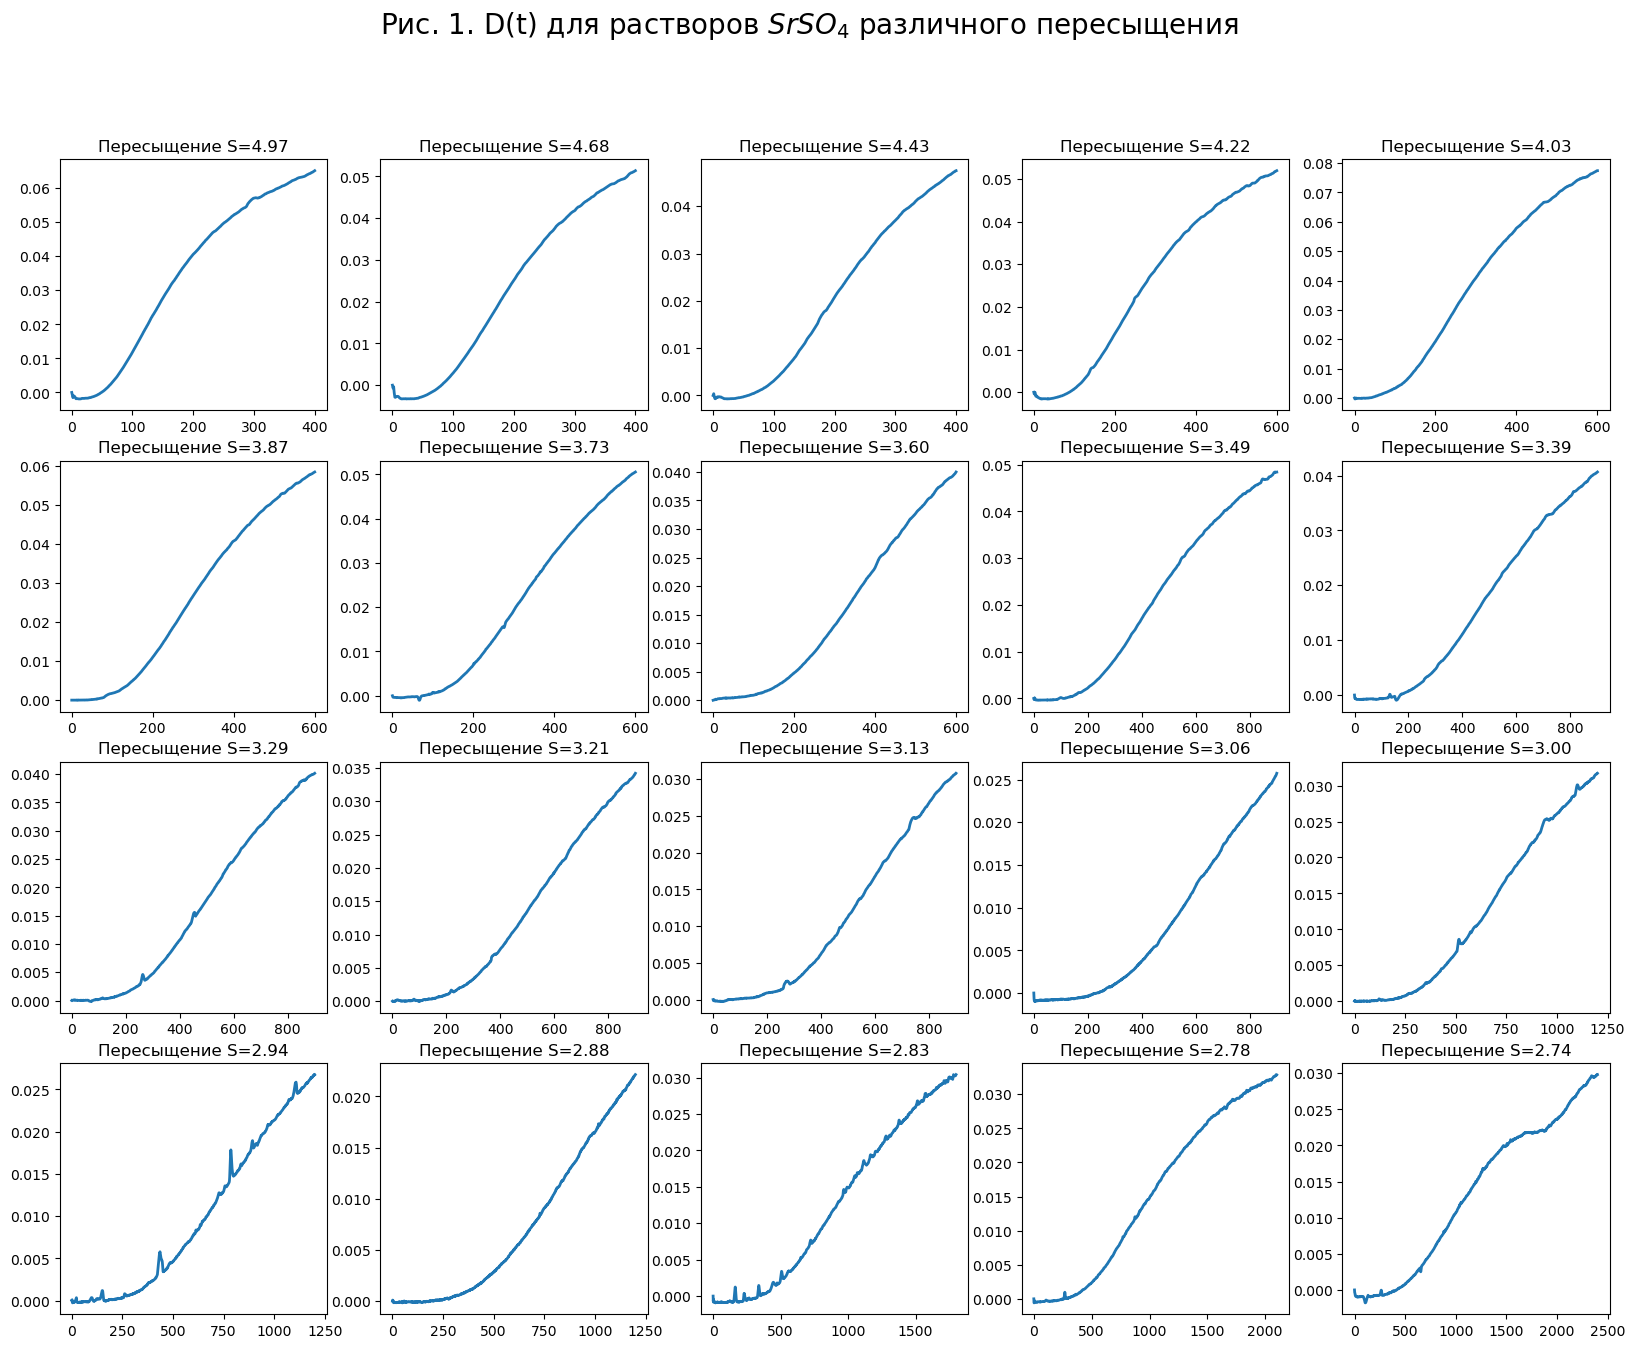

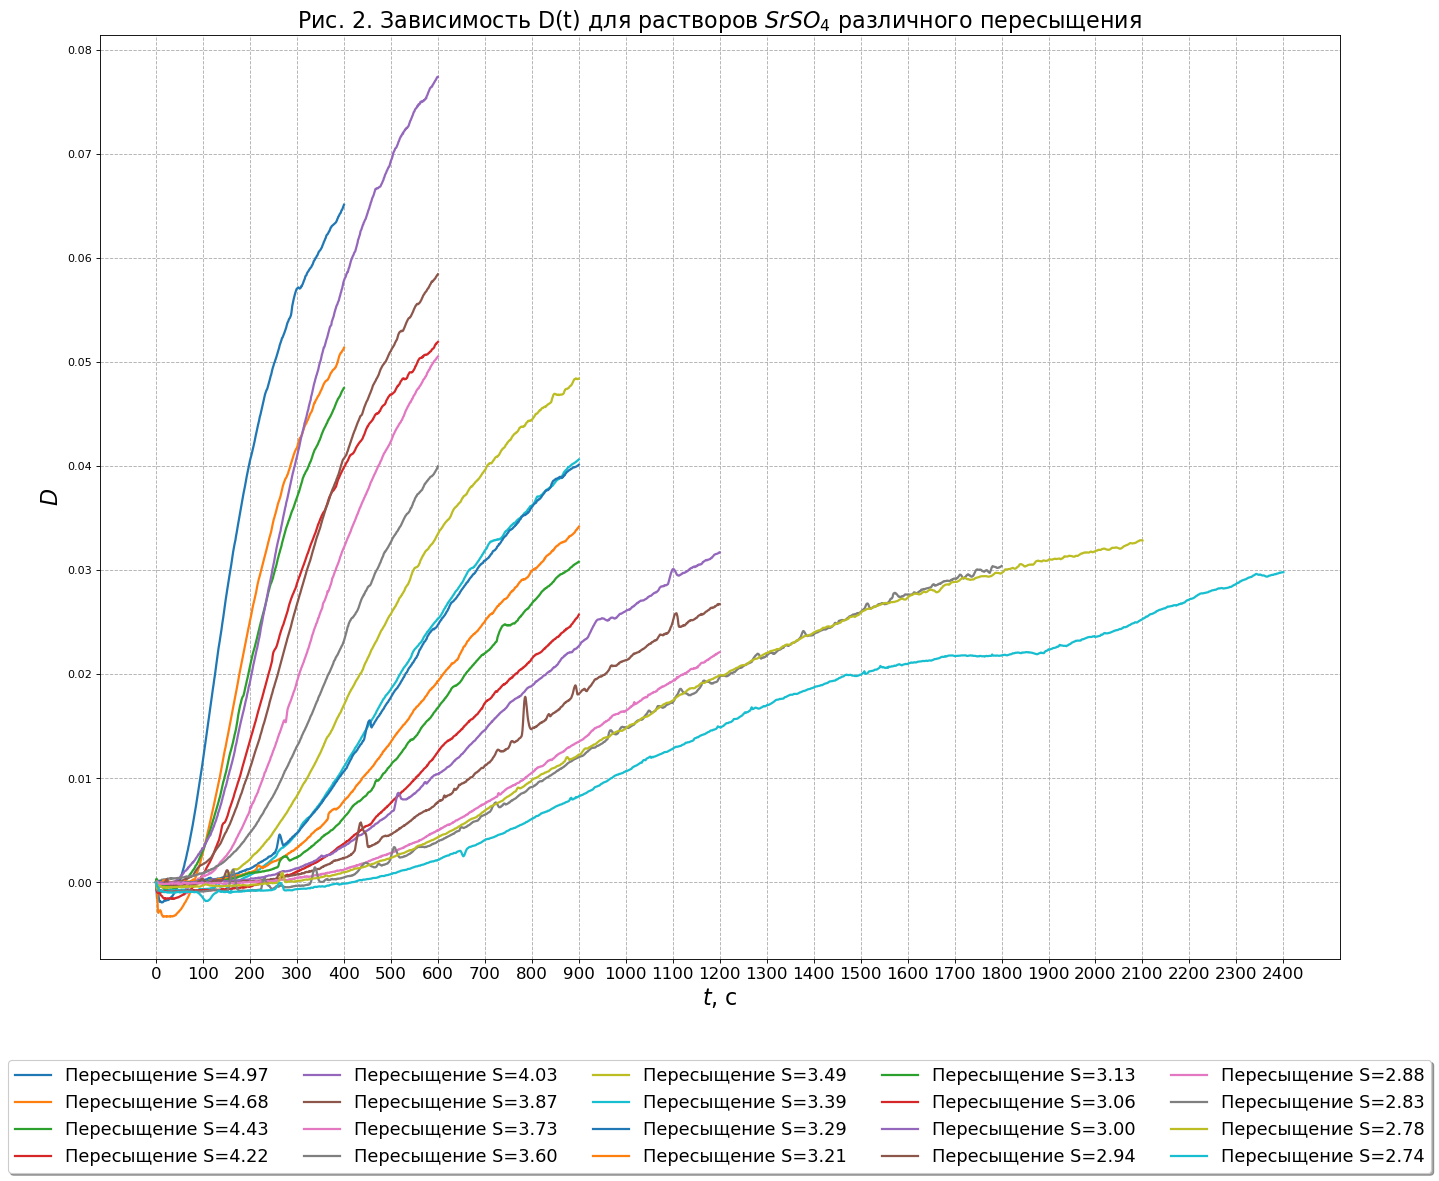

In [210]:
# Зависимость величины адсорбции от времени 
# Переводим .csv в читабельные DataFrame (DF)
Dt_dfs = [] # список, в который будем собирать DF'ы с результатами отдельных экспериментов
for _ in range(20):
    df = pd.read_csv('C%s.csv' %(_ + 1), skiprows=2,
                    names=['t, с', 'D']) # читаем .csv, пропускаем строки с названиями файла и столбцов
    df['D'] = df['D'].astype('float') / 100 # для повышения точности при конвертации данных в .csv, исходные кривые умножались на 100
    df['D'] = df['D'] - df['D'][0] # на разных спектрофотометрах разные начальные значения, даже после корректировки базовой линии
    Dt_dfs.append(df.astype('float'))
    
    
# Отрисовываем графики для каждого пересыщения 
fig, axs = plt.subplots(4, 5, figsize=(20, 15))
fig.suptitle(r'Рис. 1. D(t) для растворов $SrSO_4$ различного пересыщения', fontsize=20)
for i in range(4):
    for j in range(5):
        axs[i][j].plot(Dt_dfs[5 * i + j]['t, с'], Dt_dfs[5 * i + j]['D'], 
                      linewidth=2, label='Пересыщение S={0:.2f}'.format(recipe_fin['S'][5 * i + j]))
        axs[i][j].set_title('Пересыщение S={0:.2f}'.format(recipe_fin['S'][5 * i + j]))
        
plt.figure(figsize=(20,15), dpi=80)
plt.xticks(np.arange(0, 2500, 100), fontsize=15)
plt.xlabel(r'$t$, c', fontsize=20)
plt.ylabel(r'$D$', fontsize=20)
plt.title(r'Рис. 2. Зависимость D(t) для растворов $SrSO_4$ различного пересыщения', fontsize=20)
plt.grid(True, linestyle="--")

for _ in range(20):
    plt.plot(Dt_dfs[_]['t, с'], Dt_dfs[_]['D'], 
             linewidth=2, label='Пересыщение S={0:.2f}'.format(recipe_fin['S'][_]))
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, 
           ncol=5, prop={'size': 16})

#### *Убираю 2 последних измерения, так как они имеют очень пологие и относительно короткие линейные участки (это хорошо видно на Рис. 2) - время индукции получается отрицательным*

Из каждого графика вручную находим "линейный" срез

In [197]:
# Нахождение коэффициента поверхностного натяжения SrSO_4
# Выделение линейных участков 
lin_slices = [(100,160), (130,200), (140,210), (200,300), (200,300), # список с линейными кусками
             (240,300), (240,350), (300,380), (380,480), (400,540),
             (400,600), (400,600), (430,630), (500,700), (600,800),
             (600,700), (700,850), (750,950)]

# Находим время индукции из линейной аппроксимации этих участков
t_ind = {} # словарь формата {'значение пересыщения': время индукции}
for _ in range(18):
    k, b, r, p, slsterr = sci.linregress(Dt_dfs[_]['t, с'][lin_slices[_][0]:lin_slices[_][1]], Dt_dfs[_]['D'][lin_slices[_][0]:lin_slices[_][1]])
    t = - b / k # находим точку пересечения аппроксимирующей прямой с осью времени
    t_ind[recipe_fin['S'][_]] = t

Строим график в координатах $\frac{1}{(lnS)^2}$ и $ln \tau$, определяем величину $K_0$, чтобы по формуле $\sigma = (\frac{3 K_0 (RT)^3 \rho^2}{16 \pi \mu^2 N_A})^{\frac{1}{3}}$ посчитать коэффициент поверхностного натяжения между зародышем и раствором $SrSO_4$

<ErrorbarContainer object of 3 artists>

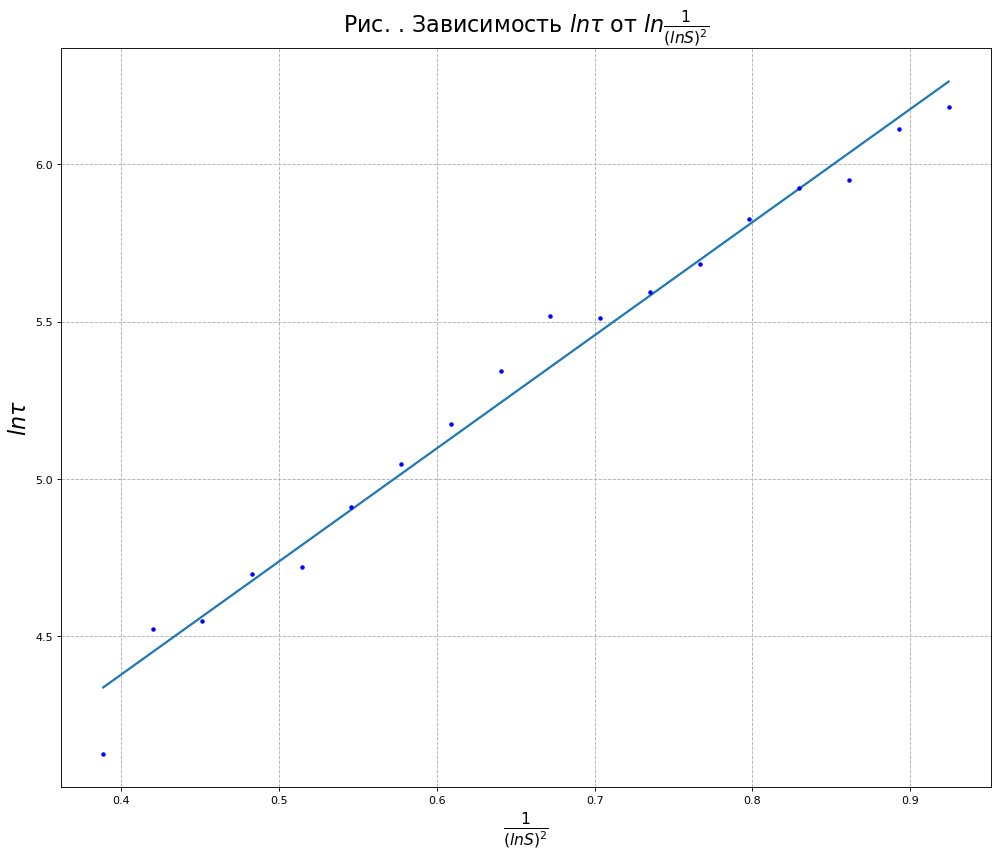

In [211]:
# Нахождение коэффициента поверхностного натяжения SrSO_4
# Строим график в линеаризующих координатах ln\tau(1/(lnS)^2)
lnS = pd.DataFrame(1 / (np.log(recipe_fin['S']))**2)
k_k0, b_k0, r, p, slsterr_k0 = sci.linregress(lnS.iloc[:18, 0], np.log(list(t_ind.values())))

plt.figure(figsize=(15,12), dpi=80)
plt.grid(True, linestyle="--")
plt.xlabel(r'$\frac{1}{(lnS)^2}$', fontsize=20)
plt.ylabel(r'$ln \tau$', fontsize=20)
plt.title(r'Рис. . Зависимость $ln \tau$ от $ln\frac{1}{(lnS)^2}$', fontsize=20)

plt.plot(lnS.iloc[:18, 0], k_k0 * lnS.iloc[:18, 0] + b_k0, 
         linewidth=2)
plt.errorbar(lnS.iloc[:18, 0], np.log(list(t_ind.values())), 
         linewidth=2, fmt='.b')

In [212]:
# Нахождение коэффициента поверхностного натяжения SrSO_4
# Находим кэффициент поверхностное натяжение SrSO_4 по формуле из крайней текстовой ячейки 
rho_srso4 = 3960 # [кг/м3]
sigma_srso4 = 1e3 * (k_k0 * 3 * (R * T)**3 * rho_srso4**2 / (16 * np.pi * mol_mass_srso4**2 * N_A))**(1 / 3)
print('Коэффициент поверхностного натяжения SrSO4, полученный из эксперимента - %d мН/м' %sigma_srso4)

Коэффициент поверхностного натяжения SrSO4, полученный из эксперимента - 13 мН/м


## Обсуждение результатов 

- недостатки спеткрофотометра - завихрения на кюветах, гетерогенное зарождение, сбивающее зависимость (у него такая же кинетика, ваще, ноооо... коэффы другие, а сколько его там - енпонятно); мерит только низ кюветы - если быстрая нуклеация, частицы быстро образуются и быстро оседают - градиент коцентрации дает неверные результаты (и исключить нельзя, так как не знаем, сколько чего уходит вниз)
- в кондуктометрии все эти недостатки устраняются - а) перемешиванием (ну, очев, что в спектрофотометре на дно мешалку не бросишь; б) металл - шероховатй, конечно, но снова - перемешивание

## Приложение 

In [196]:
# "Рецепт" приготовления раствора для каждого пересыщения
print('Табл. 1. Объемы добавляемых растворов для получения пересыщений S')

recipe_fin['n'] = [_ + 1 for _ in range(20)]
recipe_fin.set_index('n')

Табл. 1. Объемы добавляемых растворов для получения пересыщений S


,$V_{SrCl_2}$,$V_{Na_2SO_4}$,$V_{water}$,S
n,,,,
1,910.000000,910.000000,2180.000000,4.973469
2,855.996071,855.996071,2288.007857,4.678319
3,810.435759,810.435759,2379.128481,4.429316
4,771.466441,771.466441,2457.067118,4.216335
5,737.739509,737.739509,2524.520981,4.032005
6,708.250453,708.250453,2583.499094,3.870837
7,682.236000,682.236000,2635.528000,3.728659
8,659.105965,659.105965,2681.788069,3.602245
9,638.396909,638.396909,2723.206181,3.489063
